**PREPARED BY IBRAHIM ABU SAIID**

---

#**Brain Tumor Classification**

---


**CONTENT:**
1. **Introduction:** Overview of the problem and objectives of the project.
2. **Importing Libraries:** Loading necessary libraries and dependencies for data handling, visualization, and modeling.
3. **Loading and Splitting the Data:** Importing the dataset and dividing it into training, validation, and test sets.
4. **Data Visualization:**
    - Creating a bar chart to display the distribution of classes across the splits.
    - Displaying example images from each class to understand the dataset.
5. **Data Preprocessing:**
    - Setting up data generators for efficient model training.
    - Applying data augmentation and showcasing augmented examples.
6. **Model Development:** Creating, training, and evaluating four different models (CNN, VGG16, ResNet50, DenseNet121) one by one.

---

##**1. Introduction**

This project aims to classify brain tumors using MRI scan data through the application of advanced machine learning and deep learning techniques. The goal is to accurately identify tumor types to support medical professionals in diagnosis and treatment planning. To achieve this, four different deep learning models were developed and evaluated. A comprehensive comparison was performed to analyze their performance. This approach ensures that the most effective model is identified for the task, providing valuable insights into the application of artificial intelligence in medical imaging.


---

##**2. Importing Libraries**

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from math import ceil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report

---

##**3. Loading and Splitting the Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to dataset
dataset_path = '/content/drive/My Drive/Brain Tumor MRI Dataset'

In [ ]:
classes = ['No Tumor', 'Pituitary Tumor', 'Meningioma Tumor', 'Glioma Tumor']

# Directories for split dataset
split_dirs = ['train', 'validation', 'test']

In [ ]:
# Remove existing directories if they exist
for split_dir in split_dirs:
    split_path = os.path.join(dataset_path, split_dir)
    if os.path.exists(split_path):
        shutil.rmtree(split_path)

# Create directories for split dataset
for split_dir in split_dirs:
    for cls in classes:
        os.makedirs(os.path.join(dataset_path, split_dir, cls), exist_ok=True)

# Split the data
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    train_val, test = train_test_split(images, test_size=0.2, random_state=42)
    train, val = train_test_split(train_val, test_size=0.2, random_state=42)

    for img in train:
        shutil.copy(os.path.join(class_path, img), os.path.join(dataset_path, 'train', cls, img))
    for img in val:
        shutil.copy(os.path.join(class_path, img), os.path.join(dataset_path, 'validation', cls, img))
    for img in test:
        shutil.copy(os.path.join(class_path, img), os.path.join(dataset_path, 'test', cls, img))

In [ ]:
# Paths
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'validation')
test_dir = os.path.join(dataset_path, 'test')

---

##**4. Data Visualization**

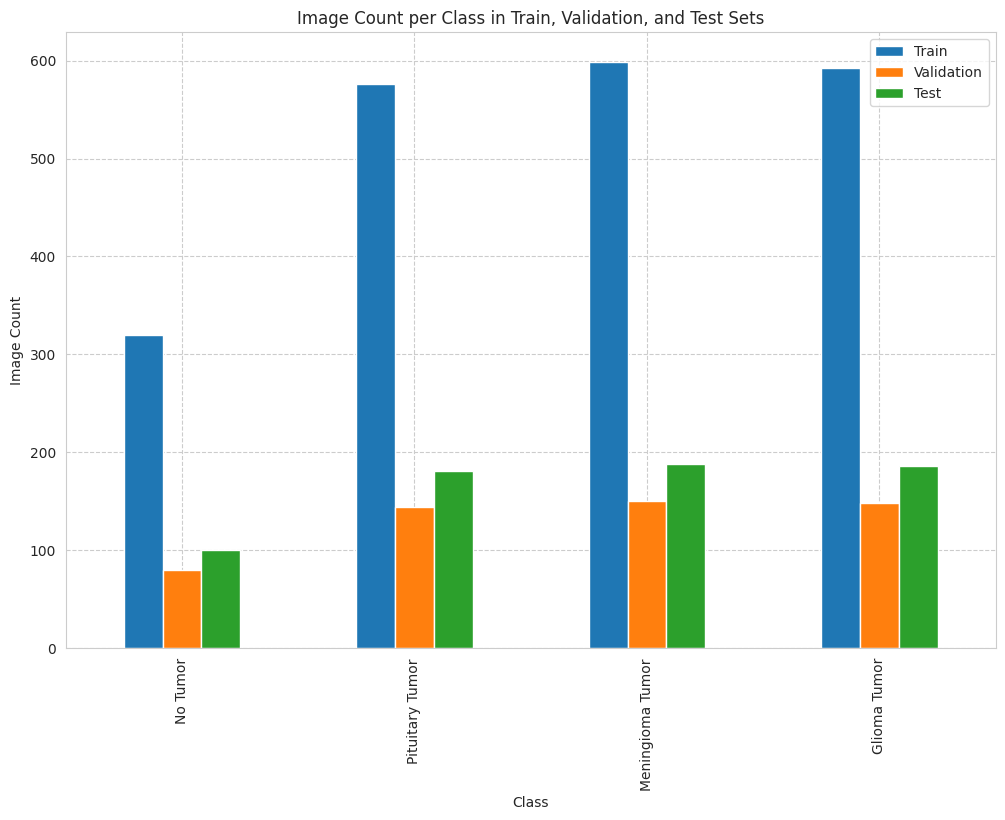

In [ ]:
# Function to count images in each class directory
def count_images_in_dirs(base_dir, classes):
    counts = {cls: 0 for cls in classes}
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        counts[cls] = len(os.listdir(class_dir))
    return counts

# Count images in each set
train_counts = count_images_in_dirs(train_dir, classes)
validation_counts = count_images_in_dirs(validation_dir, classes)
test_counts = count_images_in_dirs(test_dir, classes)

# Prepare data for plotting
counts_df = pd.DataFrame({
    'Class': classes,
    'Train': [train_counts[cls] for cls in classes],
    'Validation': [validation_counts[cls] for cls in classes],
    'Test': [test_counts[cls] for cls in classes]
})

# Plotting
# Set the style for seaborn
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Plot the stacked bar chart
counts_df.set_index('Class').plot(kind='bar', stacked=False, figsize=(12, 8))
plt.title('Image Count per Class in Train, Validation, and Test Sets')
plt.ylabel('Image Count')
plt.xlabel('Class')
plt.grid(axis='y', linestyle='--')
plt.show()

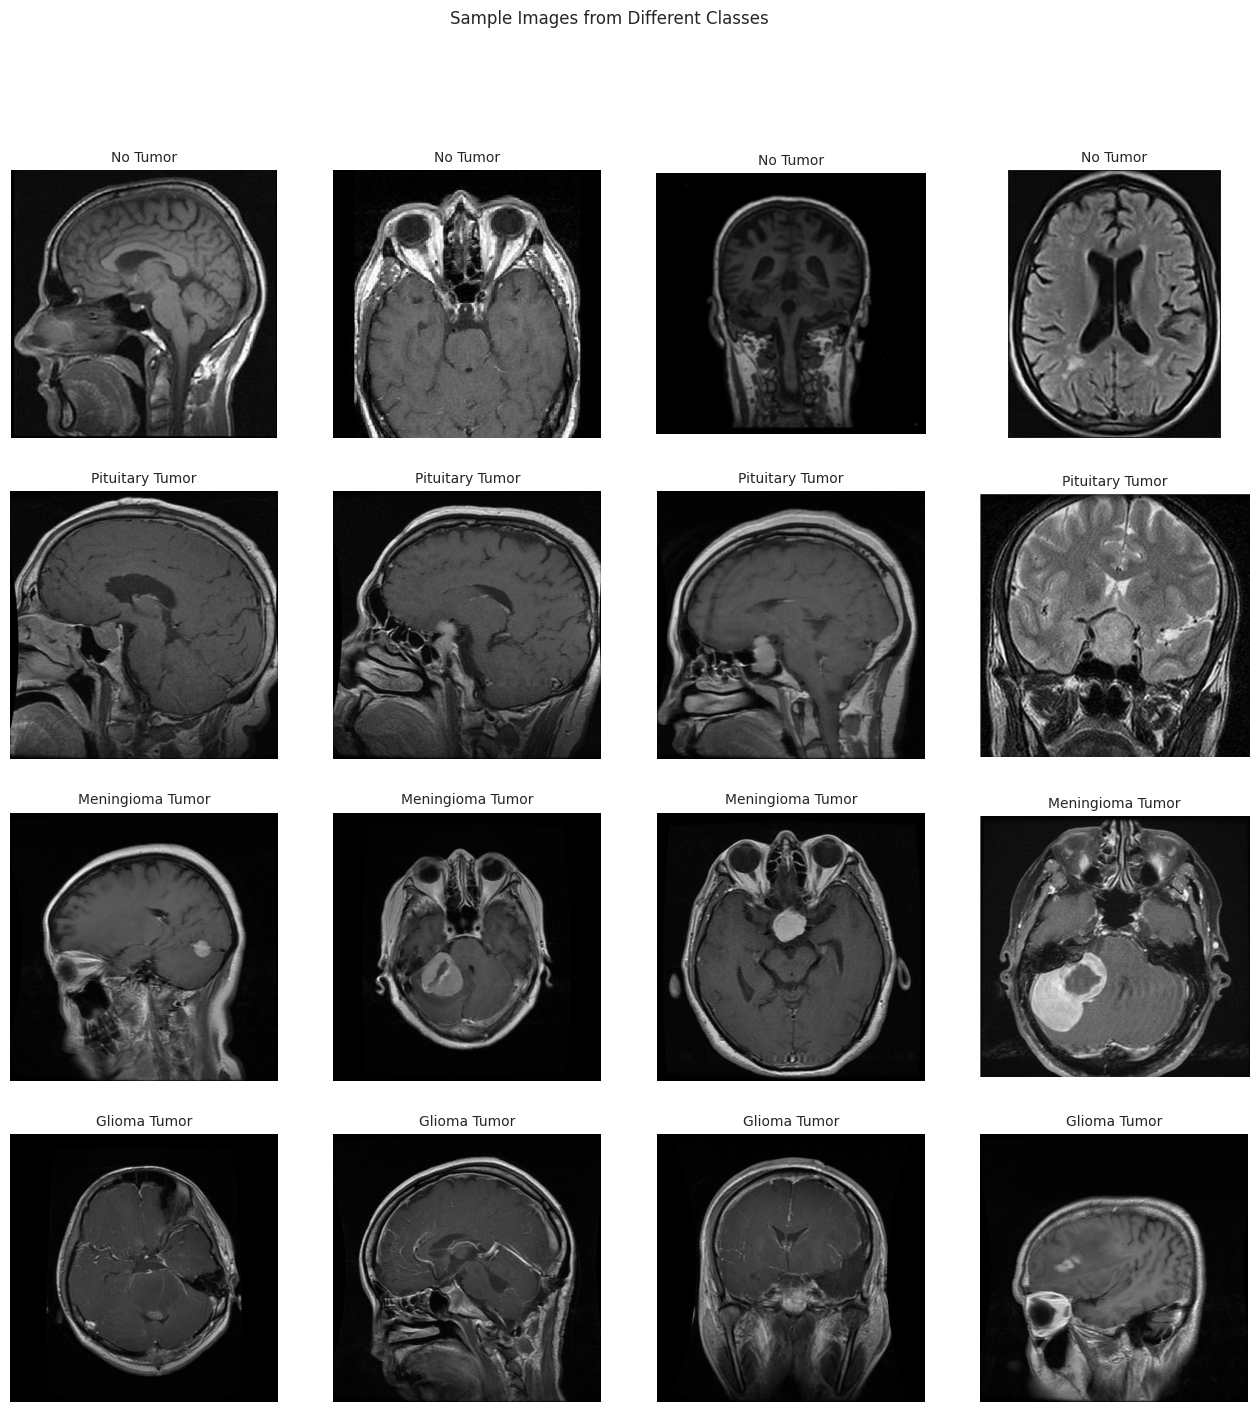

In [ ]:
from PIL import Image

# Function to display images from different classes
def show_images_from_classes(base_dir, classes, num_images=4):
    fig, axes = plt.subplots(len(classes), num_images, figsize=(num_images * 4, len(classes) * 4))

    for i, cls in enumerate(classes):
        class_dir = os.path.join(base_dir, cls)
        images = os.listdir(class_dir)
        selected_images = images[:num_images]

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(np.asarray(img))
            axes[i, j].axis('off')
            axes[i, j].set_title(cls, size='medium')  # Add class label as title

    plt.suptitle('Sample Images from Different Classes', size='large')
    plt.show()

# Display images from train set (can change to validation or test as needed)
show_images_from_classes(train_dir, classes)


---

##**5. Data Preprocessing**

In [ ]:
# Training data generator with augmented parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Reduced rotation to prevent excessive distortion
    width_shift_range=0.1,  # Reduced shift to maintain diagnostic features
    height_shift_range=0.1,  # Reduced shift to maintain diagnostic features
    zoom_range=0.1,  # Reduced zoom to avoid excessive changes
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation data generator without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Categorical for multi-class classification
    shuffle=False
)

# Test data generator without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2087 images belonging to 4 classes.
Found 522 images belonging to 4 classes.
Found 655 images belonging to 4 classes.


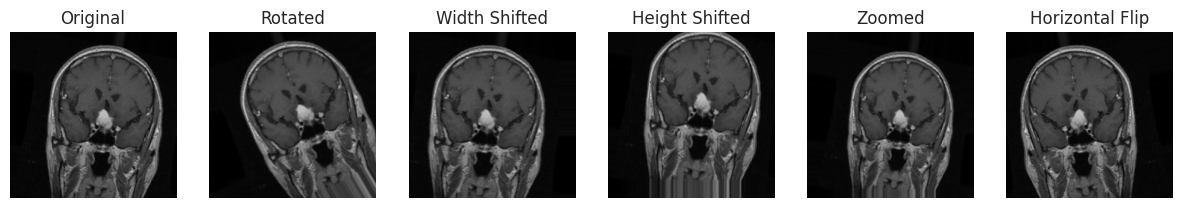

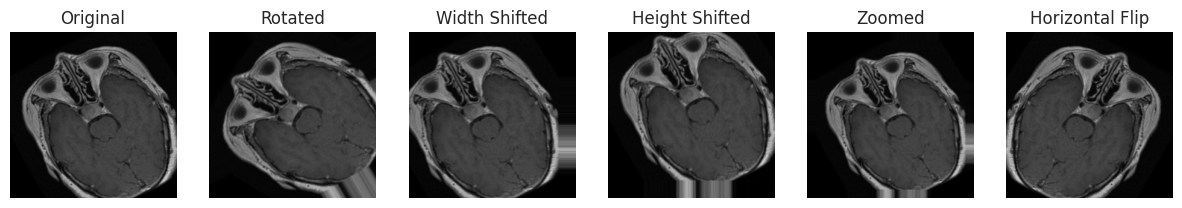

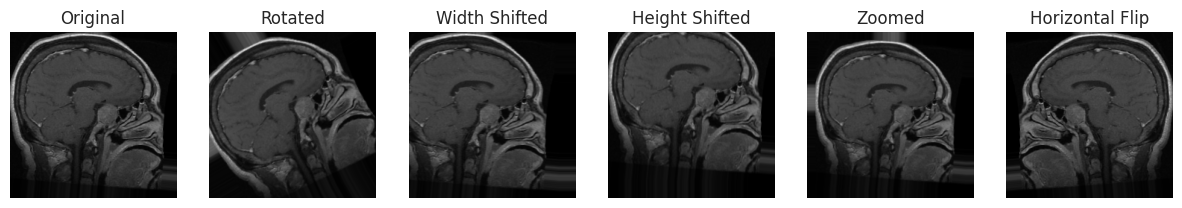

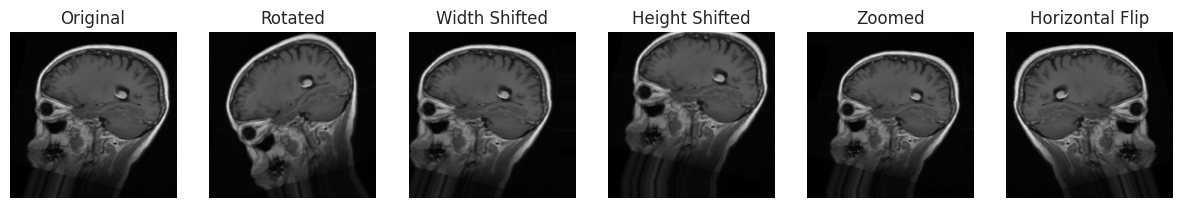

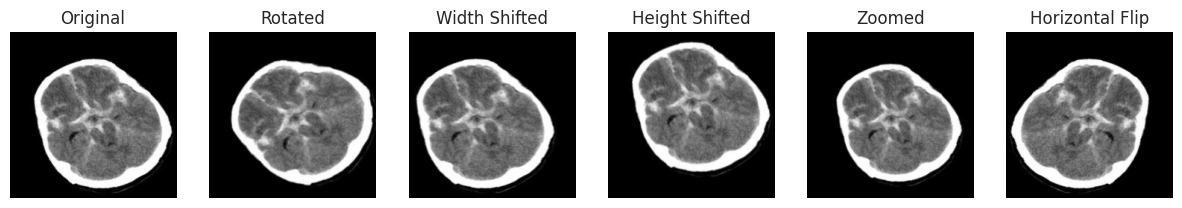

In [ ]:
import matplotlib.pyplot as plt

# Function to apply augmentations and plot the images
def plot_augmented_images(generator, augmentations, n_images=5):
    """Plot augmented images for a given number of examples."""
    for i in range(n_images):
        images, _ = next(generator)
        plt.figure(figsize=(15, 5))
        for j, (aug_name, aug_fn) in enumerate(augmentations.items()):
            augmented_image = aug_fn(images[0])
            plt.subplot(1, len(augmentations), j + 1)
            plt.imshow(augmented_image)
            plt.title(aug_name)
            plt.axis('off')
        plt.show()

# Define augmentations
augmentations = {
    'Original': lambda x: x,
    'Rotated': lambda x: train_datagen.apply_transform(x, {'theta': 30}),  # Updated rotation
    'Width Shifted': lambda x: train_datagen.apply_transform(x, {'tx': 0.1 * x.shape[1]}),
    'Height Shifted': lambda x: train_datagen.apply_transform(x, {'ty': 0.1 * x.shape[0]}),
    'Zoomed': lambda x: train_datagen.apply_transform(x, {'zx': 1.1, 'zy': 1.1}),
    'Horizontal Flip': lambda x: train_datagen.apply_transform(x, {'flip_horizontal': True}),
}

# Plot augmented images
plot_augmented_images(train_generator, augmentations)


---

##**6. Model Development**

Epoch 1/50
66/66 [==============================] - 53s 667ms/step - loss: 1.3165 - accuracy: 0.3690 - val_loss: 1.2068 - val_accuracy: 0.4770
Epoch 2/50
66/66 [==============================] - 44s 661ms/step - loss: 1.2121 - accuracy: 0.4475 - val_loss: 1.0424 - val_accuracy: 0.5709
Epoch 3/50
66/66 [==============================] - 43s 657ms/step - loss: 1.1190 - accuracy: 0.5098 - val_loss: 0.9852 - val_accuracy: 0.5766
Epoch 4/50
66/66 [==============================] - 44s 670ms/step - loss: 1.0327 - accuracy: 0.5496 - val_loss: 0.8976 - val_accuracy: 0.6264
Epoch 5/50
66/66 [==============================] - 53s 807ms/step - loss: 0.9990 - accuracy: 0.5865 - val_loss: 0.8555 - val_accuracy: 0.6284
Epoch 6/50
66/66 [==============================] - 44s 666ms/step - loss: 0.9322 - accuracy: 0.5956 - val_loss: 0.8264 - val_accuracy: 0.6398
Epoch 7/50
66/66 [==============================] - 48s 737ms/step - loss: 0.8674 - accuracy: 0.6339 - val_loss: 0.7654 - val_accuracy: 0.6705

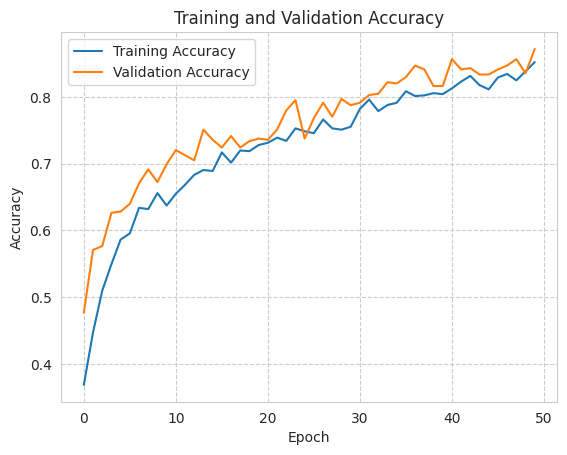

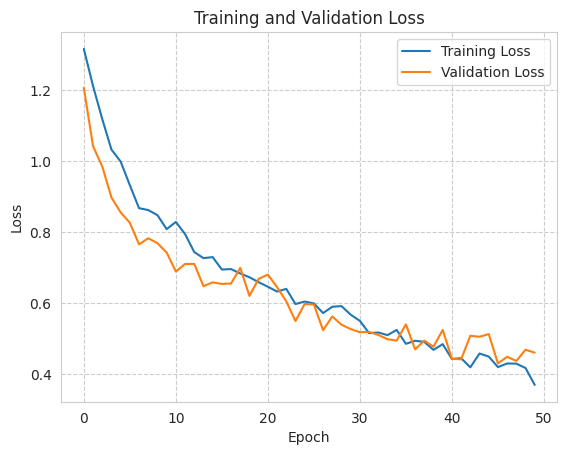

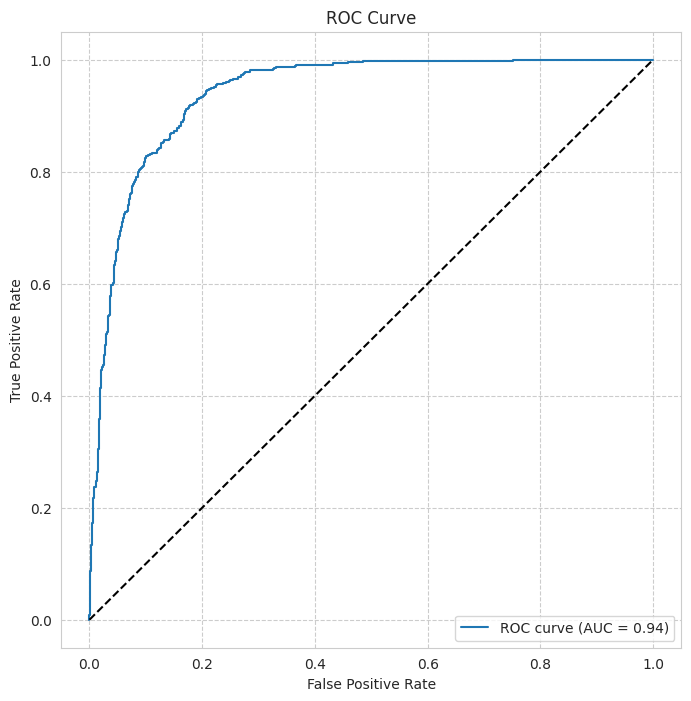

In [ ]:
# Custom callback to print a message when early stopping is triggered
class CustomEarlyStopping(EarlyStopping):
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Early stopping triggered at epoch {self.stopped_epoch + 1}")

# Define the CNN model for multi-class classification
def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(4, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile a new instance of the CNN model
cnn_model = create_cnn_model()

# Early stopping callback
early_stopping = CustomEarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model with early stopping
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_steps = ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = cnn_model.predict(validation_generator, steps=val_steps, verbose=1)
y_true = validation_generator.classes  # Ensure matching lengths
y_pred_classes = np.argmax(y_pred, axis=1)

if len(np.unique(y_true)) > 1:
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred_classes)
    auc_score = roc_auc_score(to_categorical(y_true), y_pred, average='macro')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true, y_pred_classes)
    class_report = classification_report(y_true, y_pred_classes)

    # Print evaluation metrics
    print(f"Accuracy: {acc}")
    print(f"AUC: {auc_score}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix: \n{cm}\n")
    print(f"Classification Report: \n{class_report}\n")

# Plot training and validation accuracy
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(to_categorical(y_true).ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Check if a model with the same name exists in the dataset path
model_path = os.path.join(dataset_path, "cnn.h5")

if os.path.exists(model_path):
    # If a model with the same name exists, delete it
    os.remove(model_path)
    print(f"Existing model {model_path} removed.")

# Save the trained model
cnn_model.save(model_path)
print(f"Model saved at {model_path}")

Model saved at /content/drive/My Drive/Brain Tumor MRI Dataset/cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 4s 199ms/step
Test Set Results:
Accuracy: 0.8595419847328244
AUC: 0.9340622891904986
F1 Score: 0.8598249653914692
Precision: 0.8653555306723892
Recall: 0.8595419847328244
Confusion Matrix: 
[[149  27   9   1]
 [  8 152  19   9]
 [  1   2  96   1]
 [  5  10   0 166]]



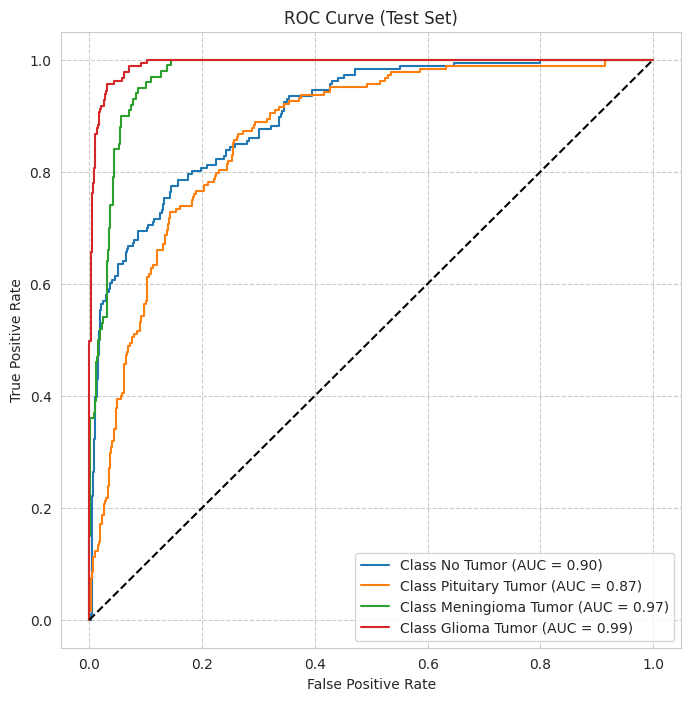

Classification Report on Test Set:
                  precision    recall  f1-score   support

        No Tumor       0.91      0.80      0.85       186
 Pituitary Tumor       0.80      0.81      0.80       188
Meningioma Tumor       0.77      0.96      0.86       100
    Glioma Tumor       0.94      0.92      0.93       181

        accuracy                           0.86       655
       macro avg       0.86      0.87      0.86       655
    weighted avg       0.87      0.86      0.86       655



In [ ]:
# Final evaluation on the test set
test_steps = ceil(test_generator.samples / test_generator.batch_size)
y_pred_test = cnn_model.predict(test_generator, steps=test_steps, verbose=1)
y_true_test = test_generator.classes  # Ensure matching lengths
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

# Calculate metrics on the test set
acc_test = accuracy_score(y_true_test, y_pred_classes_test)
cnn_auc_score_test = roc_auc_score(to_categorical(y_true_test), y_pred_test, multi_class='ovo')
f1_test = f1_score(y_true_test, y_pred_classes_test, average='weighted')
precision_test = precision_score(y_true_test, y_pred_classes_test, average='weighted')
recall_test = recall_score(y_true_test, y_pred_classes_test, average='weighted')
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)

# ROC curve on test set
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_test == i, y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Display results on the test set
print("Test Set Results:")
print(f"Accuracy: {acc_test}")
print(f"AUC: {cnn_auc_score_test}")
print(f"F1 Score: {f1_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"Confusion Matrix: \n{cm_test}\n")

# Plot ROC curve on test set
plt.figure(figsize=(8, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()

# Classification report on test set
print("Classification Report on Test Set:")
print(classification_report(y_true_test, y_pred_classes_test, target_names=classes))


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
66/66 [==============================] - 56s 741ms/step - loss: 1.8242 - accuracy: 0.3445 - val_loss: 1.1737 - val_accuracy: 0.4636
Epoch 2/50
66/66 [==============================] - 45s 679ms/step - loss: 1.1831 - accuracy: 0.4317 - val_loss: 0.9986 - val_accuracy: 0.6686
Epoch 3/50
66/66 [==============================] - 45s 677ms/step - loss: 1.1087 - accuracy: 0.4701 - val_loss: 0.8628 - val_accuracy: 0.7318
Epoch 4/50
66/66 [==============================] - 45s 687ms/step - loss: 1.0654 - accuracy: 0.4868 - val_loss: 0.7572 - val_accuracy: 0.7050
Epoch 5/50
66/66 [==============================] - 47s 702ms/step - loss: 1.0023 - accuracy: 0.5127 - val_loss: 0.7416 - val_accuracy: 0.7356
Epoch 6/50
66/66 [==============================] - 44s 667ms/step - loss: 0.9574 - accuracy: 0.5520 - val_loss: 0.7003 - val_accuracy: 0.7471
Epoch 7/50
66/66 [==============================] - 45s 682ms/step - loss: 0.

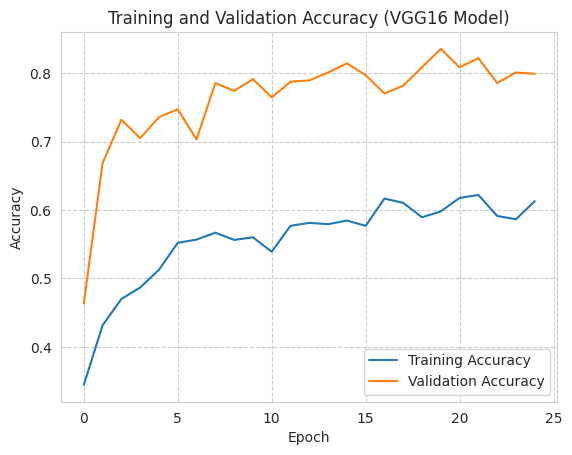

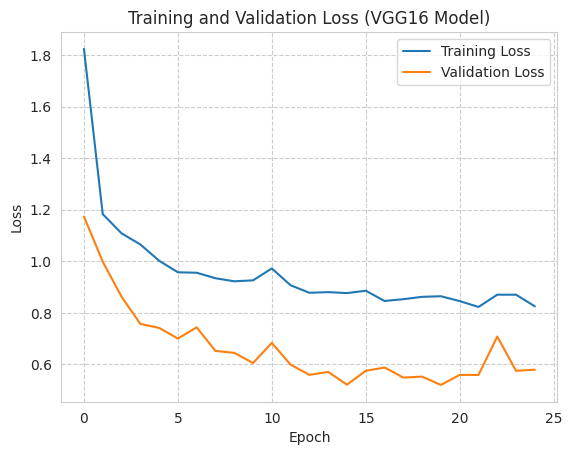

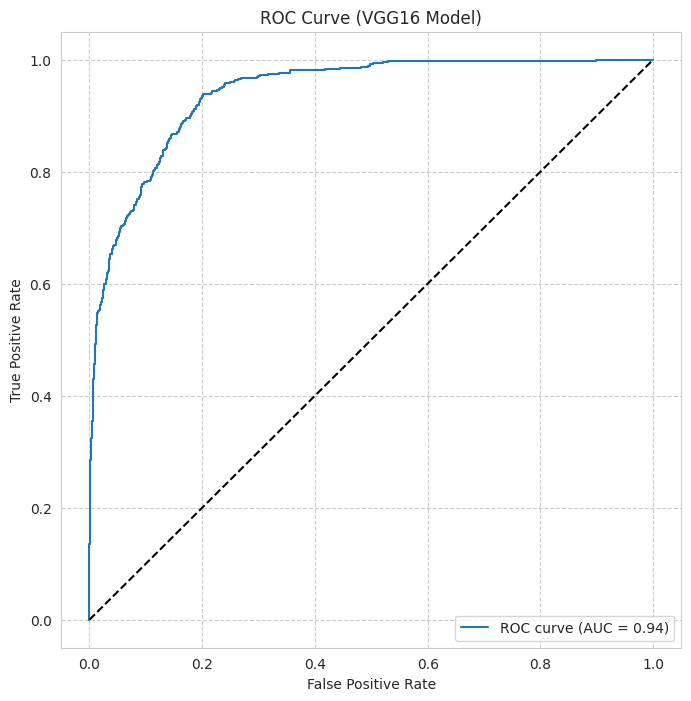

In [ ]:
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the pre-trained layers

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(4, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile a new instance of the VGG16-based model
vgg16_model = create_vgg16_model()

# Early stopping callback
early_stopping = CustomEarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model with early stopping
history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_steps = ceil(validation_generator.samples / validation_generator.batch_size)
y_pred_vgg16 = vgg16_model.predict(validation_generator, steps=val_steps, verbose=1)
y_true = validation_generator.classes  # Ensure matching lengths
y_pred_classes_vgg16 = np.argmax(y_pred_vgg16, axis=1)

if len(np.unique(y_true)) > 1:
    # Calculate metrics
    acc_vgg16 = accuracy_score(y_true, y_pred_classes_vgg16)
    auc_score_vgg16 = roc_auc_score(to_categorical(y_true), y_pred_vgg16, average='macro')
    f1_vgg16 = f1_score(y_true, y_pred_classes_vgg16, average='weighted')
    precision_vgg16 = precision_score(y_true, y_pred_classes_vgg16, average='weighted')
    recall_vgg16 = recall_score(y_true, y_pred_classes_vgg16, average='weighted')
    cm_vgg16 = confusion_matrix(y_true, y_pred_classes_vgg16)
    class_report_vgg16 = classification_report(y_true, y_pred_classes_vgg16)

    # Print evaluation metrics
    print(f"VGG16 Model Evaluation:")
    print(f"Accuracy: {acc_vgg16}")
    print(f"AUC: {auc_score_vgg16}")
    print(f"F1 Score: {f1_vgg16}")
    print(f"Precision: {precision_vgg16}")
    print(f"Recall: {recall_vgg16}")
    print(f"Confusion Matrix: \n{cm_vgg16}\n")
    print(f"Classification Report: \n{class_report_vgg16}\n")

# Plot training and validation accuracy
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (VGG16 Model)')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (VGG16 Model)')
plt.legend()
plt.show()

# Calculate ROC curve
fpr_vgg16, tpr_vgg16, _ = roc_curve(to_categorical(y_true).ravel(), y_pred_vgg16.ravel())
roc_auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_vgg16, tpr_vgg16, label=f'ROC curve (AUC = {roc_auc_vgg16:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (VGG16 Model)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Check if a model with the same name exists in the dataset path
model_path = os.path.join(dataset_path, "vgg16.h5")

if os.path.exists(model_path):
    # If a model with the same name exists, delete it
    os.remove(model_path)
    print(f"Existing model {model_path} removed.")

# Save the trained model
vgg16_model.save(model_path)
print(f"Model saved at {model_path}")

Model saved at /content/drive/My Drive/Brain Tumor MRI Dataset/vgg16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 8s 376ms/step
Test Set Results:
Accuracy: 0.8427480916030534
AUC: 0.9410435077710937
F1 Score: 0.8404587918866967
Precision: 0.846384272421307
Recall: 0.8427480916030534
Confusion Matrix: 
[[139  38   7   2]
 [  9 144  10  25]
 [  3   3  90   4]
 [  0   2   0 179]]



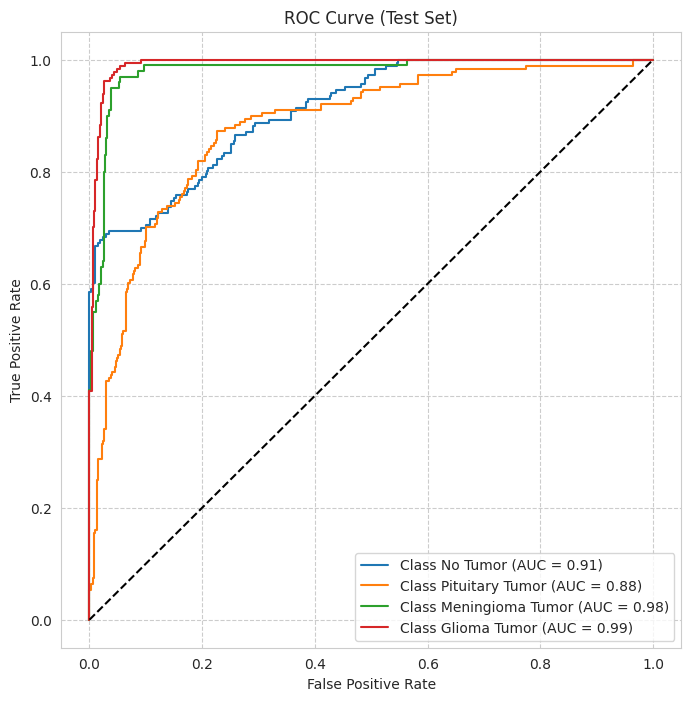

Classification Report on Test Set:
                  precision    recall  f1-score   support

        No Tumor       0.92      0.75      0.82       186
 Pituitary Tumor       0.77      0.77      0.77       188
Meningioma Tumor       0.84      0.90      0.87       100
    Glioma Tumor       0.85      0.99      0.92       181

        accuracy                           0.84       655
       macro avg       0.85      0.85      0.84       655
    weighted avg       0.85      0.84      0.84       655



In [ ]:
test_steps = ceil(test_generator.samples / test_generator.batch_size)
y_pred_test = vgg16_model.predict(test_generator, steps=test_steps, verbose=1)
y_true_test = test_generator.classes  # Ensure matching lengths
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

# Calculate metrics on the test set
acc_test = accuracy_score(y_true_test, y_pred_classes_test)
vgg16_auc_score_test = roc_auc_score(to_categorical(y_true_test), y_pred_test, multi_class='ovo')
f1_test = f1_score(y_true_test, y_pred_classes_test, average='weighted')
precision_test = precision_score(y_true_test, y_pred_classes_test, average='weighted')
recall_test = recall_score(y_true_test, y_pred_classes_test, average='weighted')
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)

# ROC curve on test set
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_test == i, y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Display results on the test set
print("Test Set Results:")
print(f"Accuracy: {acc_test}")
print(f"AUC: {vgg16_auc_score_test}")
print(f"F1 Score: {f1_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"Confusion Matrix: \n{cm_test}\n")

# Plot ROC curve on test set
plt.figure(figsize=(8, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()

# Classification report on test set
print("Classification Report on Test Set:")
print(classification_report(y_true_test, y_pred_classes_test, target_names=classes))


94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/50
66/66 [==============================] - 49s 649ms/step - loss: 2.8381 - accuracy: 0.2952 - val_loss: 1.3707 - val_accuracy: 0.2969
Epoch 2/50
66/66 [==============================] - 43s 656ms/step - loss: 1.4252 - accuracy: 0.2798 - val_loss: 1.3759 - val_accuracy: 0.2874
Epoch 3/50
66/66 [==============================] - 44s 668ms/step - loss: 1.3746 - accuracy: 0.2870 - val_loss: 1.3681 - val_accuracy: 0.2874
Epoch 4/50
66/66 [==============================] - 45s 676ms/step - loss: 1.3697 - accuracy: 0.2870 - val_loss: 1.3469 - val_accuracy: 0.2874
Epoch 5/50
66/66 [==============================] - 44s 667ms/step - loss: 1.3728 - accuracy: 0.2774 - val_loss: 1.3500 - val_accuracy: 0.2989
Epoch 6/50
66/66 [==============================] - 45s 680ms/step - loss: 1.3583 - accuracy: 0.2923 - val_loss: 1.3425 - val_accuracy: 0.3008
Epoch 7/50
66/66 [==============================] - 45s 677ms/step - loss: 1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

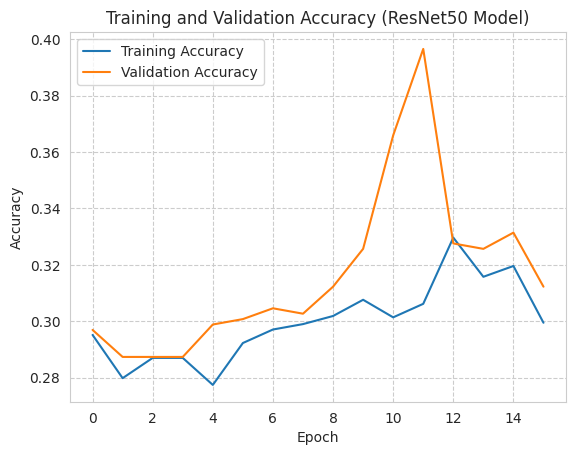

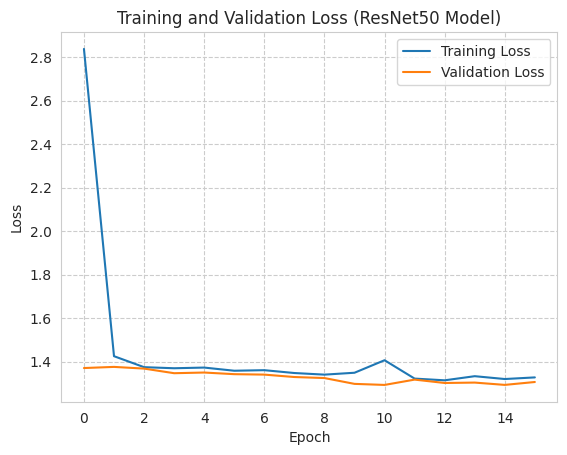

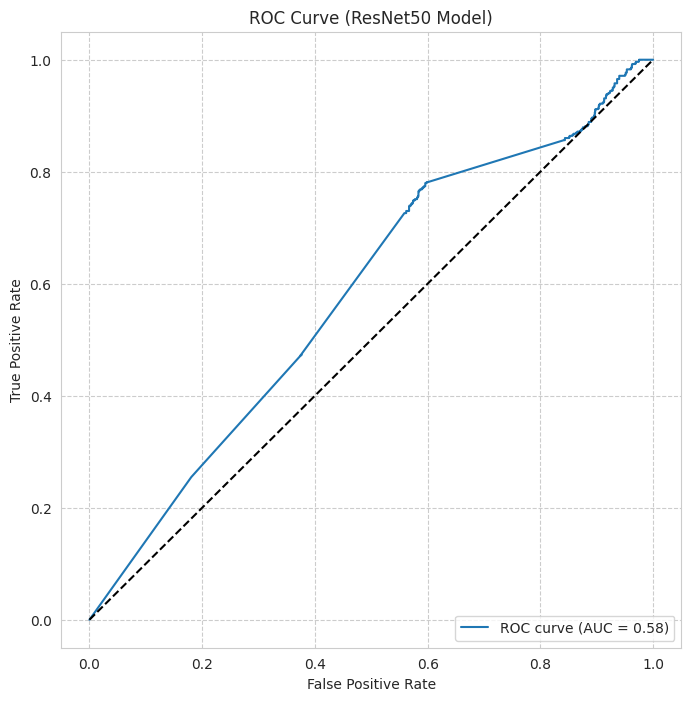

In [ ]:
def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the pre-trained layers

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(4, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile a new instance of the ResNet50-based model
resnet50_model = create_resnet50_model()

# Early stopping callback
early_stopping = CustomEarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model with early stopping
history_resnet50 = resnet50_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_steps = ceil(validation_generator.samples / validation_generator.batch_size)
y_pred_resnet50 = resnet50_model.predict(validation_generator, steps=val_steps, verbose=1)
y_true = validation_generator.classes  # Ensure matching lengths
y_pred_classes_resnet50 = np.argmax(y_pred_resnet50, axis=1)

if len(np.unique(y_true)) > 1:
    # Calculate metrics
    acc_resnet50 = accuracy_score(y_true, y_pred_classes_resnet50)
    auc_score_resnet50 = roc_auc_score(to_categorical(y_true), y_pred_resnet50, average='macro')
    f1_resnet50 = f1_score(y_true, y_pred_classes_resnet50, average='weighted')
    precision_resnet50 = precision_score(y_true, y_pred_classes_resnet50, average='weighted')
    recall_resnet50 = recall_score(y_true, y_pred_classes_resnet50, average='weighted')
    cm_resnet50 = confusion_matrix(y_true, y_pred_classes_resnet50)
    class_report_resnet50 = classification_report(y_true, y_pred_classes_resnet50)

    # Print evaluation metrics
    print(f"ResNet50 Model Evaluation:")
    print(f"Accuracy: {acc_resnet50}")
    print(f"AUC: {auc_score_resnet50}")
    print(f"F1 Score: {f1_resnet50}")
    print(f"Precision: {precision_resnet50}")
    print(f"Recall: {recall_resnet50}")
    print(f"Confusion Matrix: \n{cm_resnet50}\n")
    print(f"Classification Report: \n{class_report_resnet50}\n")

# Plot training and validation accuracy
plt.plot(history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (ResNet50 Model)')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ResNet50 Model)')
plt.legend()
plt.show()

# Calculate ROC curve
fpr_resnet50, tpr_resnet50, _ = roc_curve(to_categorical(y_true).ravel(), y_pred_resnet50.ravel())
roc_auc_resnet50 = auc(fpr_resnet50, tpr_resnet50)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_resnet50, tpr_resnet50, label=f'ROC curve (AUC = {roc_auc_resnet50:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (ResNet50 Model)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Check if a model with the same name exists in the dataset path
model_path = os.path.join(dataset_path, "resnet50.h5")

if os.path.exists(model_path):
    # If a model with the same name exists, delete it
    os.remove(model_path)
    print(f"Existing model {model_path} removed.")

# Save the trained model
resnet50_model.save(model_path)
print(f"Model saved at {model_path}")

Model saved at /content/drive/My Drive/Brain Tumor MRI Dataset/resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 5s 252ms/step
Test Set Results:
Accuracy: 0.37709923664122136
AUC: 0.47626249858926273
F1 Score: 0.28582912243495406
Precision: 0.3195895248347747
Recall: 0.37709923664122136
Confusion Matrix: 
[[171   8   7   0]
 [148  26  14   0]
 [ 39  11  50   0]
 [163  17   1   0]]



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


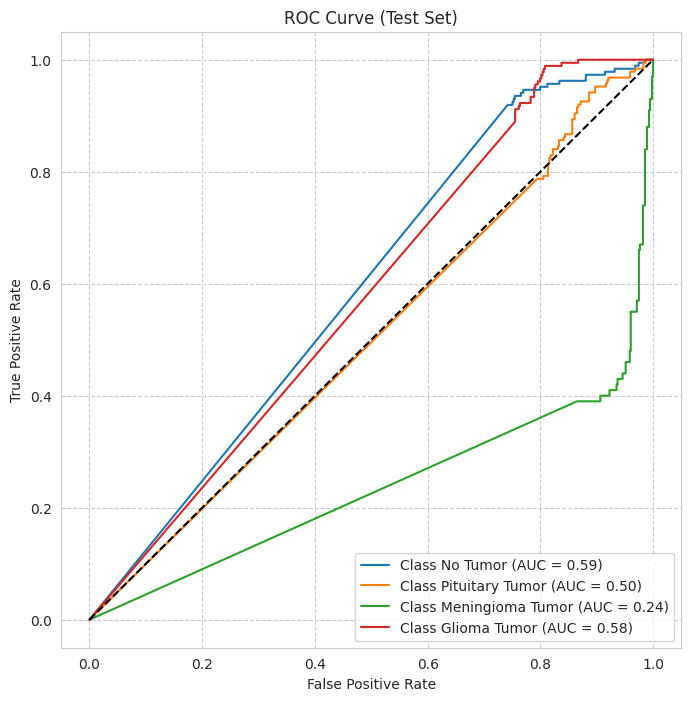

Classification Report on Test Set:
                  precision    recall  f1-score   support

        No Tumor       0.33      0.92      0.48       186
 Pituitary Tumor       0.42      0.14      0.21       188
Meningioma Tumor       0.69      0.50      0.58       100
    Glioma Tumor       0.00      0.00      0.00       181

        accuracy                           0.38       655
       macro avg       0.36      0.39      0.32       655
    weighted avg       0.32      0.38      0.29       655



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_steps = ceil(test_generator.samples / test_generator.batch_size)
y_pred_test = resnet50_model.predict(test_generator, steps=test_steps, verbose=1)
y_true_test = test_generator.classes  # Ensure matching lengths
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

# Calculate metrics on the test set
acc_test = accuracy_score(y_true_test, y_pred_classes_test)
resnet50_auc_score_test = roc_auc_score(to_categorical(y_true_test), y_pred_test, multi_class='ovo')
f1_test = f1_score(y_true_test, y_pred_classes_test, average='weighted')
precision_test = precision_score(y_true_test, y_pred_classes_test, average='weighted')
recall_test = recall_score(y_true_test, y_pred_classes_test, average='weighted')
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)

# ROC curve on test set
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_test == i, y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Display results on the test set
print("Test Set Results:")
print(f"Accuracy: {acc_test}")
print(f"AUC: {resnet50_auc_score_test}")
print(f"F1 Score: {f1_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"Confusion Matrix: \n{cm_test}\n")

# Plot ROC curve on test set
plt.figure(figsize=(8, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()

# Classification report on test set
print("Classification Report on Test Set:")
print(classification_report(y_true_test, y_pred_classes_test, target_names=classes))

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/50
66/66 [==============================] - 62s 744ms/step - loss: 1.2127 - accuracy: 0.5218 - val_loss: 0.7906 - val_accuracy: 0.7203
Epoch 2/50
66/66 [==============================] - 43s 658ms/step - loss: 0.8332 - accuracy: 0.6564 - val_loss: 0.6327 - val_accuracy: 0.7625
Epoch 3/50
66/66 [==============================] - 44s 664ms/step - loss: 0.7474 - accuracy: 0.7053 - val_loss: 0.5615 - val_accuracy: 0.8084
Epoch 4/50
66/66 [==============================] - 44s 663ms/step - loss: 0.6812 - accuracy: 0.7437 - val_loss: 0.5511 - val_accuracy: 0.8027
Epoch 5/50
66/66 [==============================] - 44s 671ms/step - loss: 0.6457 - accuracy: 0.7585 - val_loss: 0.5503 - val_accuracy: 0.8218
Epoch 6/50
66/66 [==============================] - 45s 681ms/step - loss: 0.6153 - accuracy: 0.7643 - val_loss: 0.5012 - val_accuracy: 0.8046
Epoch 7/50
66/66 [==============================] - 43s 656ms/step - loss: 0.

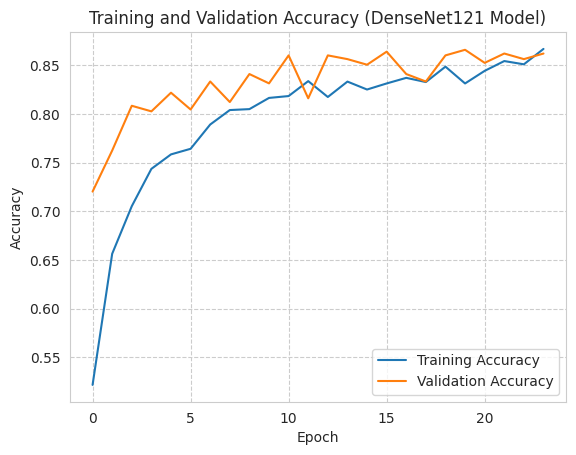

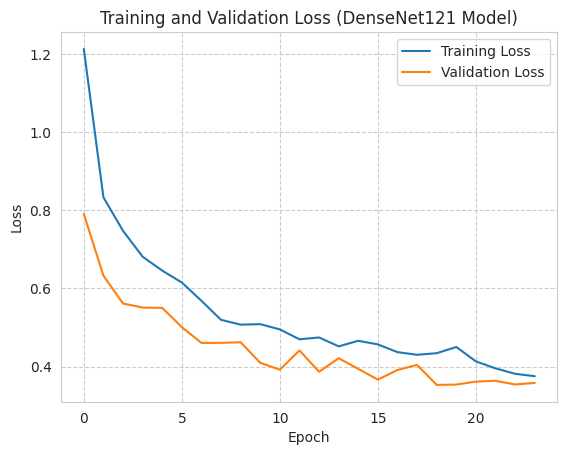

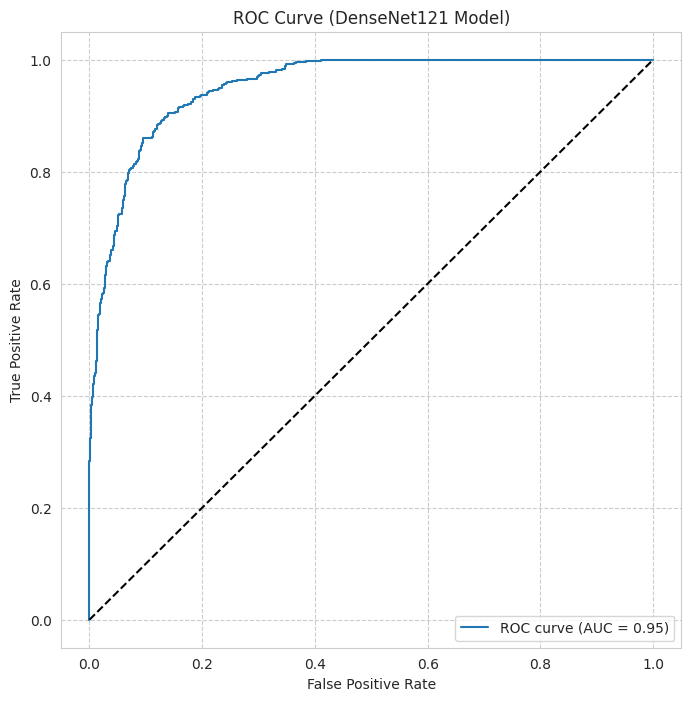

In [ ]:
def create_densenet121_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the pre-trained layers

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(4, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile a new instance of the DenseNet121-based model
densenet121_model = create_densenet121_model()

# Early stopping callback
early_stopping = CustomEarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model with early stopping
history_densenet121 = densenet121_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    verbose=1,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_steps = ceil(validation_generator.samples / validation_generator.batch_size)
y_pred_densenet121 = densenet121_model.predict(validation_generator, steps=val_steps, verbose=1)
y_true = validation_generator.classes  # Ensure matching lengths
y_pred_classes_densenet121 = np.argmax(y_pred_densenet121, axis=1)

if len(np.unique(y_true)) > 1:
    # Calculate metrics
    acc_densenet121 = accuracy_score(y_true, y_pred_classes_densenet121)
    auc_score_densenet121 = roc_auc_score(to_categorical(y_true), y_pred_densenet121, average='macro')
    f1_densenet121 = f1_score(y_true, y_pred_classes_densenet121, average='weighted')
    precision_densenet121 = precision_score(y_true, y_pred_classes_densenet121, average='weighted')
    recall_densenet121 = recall_score(y_true, y_pred_classes_densenet121, average='weighted')
    cm_densenet121 = confusion_matrix(y_true, y_pred_classes_densenet121)
    class_report_densenet121 = classification_report(y_true, y_pred_classes_densenet121)

    # Print evaluation metrics
    print(f"DenseNet121 Model Evaluation:")
    print(f"Accuracy: {acc_densenet121}")
    print(f"AUC: {auc_score_densenet121}")
    print(f"F1 Score: {f1_densenet121}")
    print(f"Precision: {precision_densenet121}")
    print(f"Recall: {recall_densenet121}")
    print(f"Confusion Matrix: \n{cm_densenet121}\n")
    print(f"Classification Report: \n{class_report_densenet121}\n")

# Plot training and validation accuracy
plt.plot(history_densenet121.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet121.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (DenseNet121 Model)')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_densenet121.history['loss'], label='Training Loss')
plt.plot(history_densenet121.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (DenseNet121 Model)')
plt.legend()
plt.show()

# Calculate ROC curve
fpr_densenet121, tpr_densenet121, _ = roc_curve(to_categorical(y_true).ravel(), y_pred_densenet121.ravel())
roc_auc_densenet121 = auc(fpr_densenet121, tpr_densenet121)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_densenet121, tpr_densenet121, label=f'ROC curve (AUC = {roc_auc_densenet121:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (DenseNet121 Model)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Check if a model with the same name exists in the dataset path
model_path = os.path.join(dataset_path, "densenet121.h5")

if os.path.exists(model_path):
    # If a model with the same name exists, delete it
    os.remove(model_path)
    print(f"Existing model {model_path} removed.")

# Save the trained model
densenet121_model.save(model_path)
print(f"Model saved at {model_path}")

Model saved at /content/drive/My Drive/Brain Tumor MRI Dataset/densenet121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 7s 347ms/step
Test Set Results:
Accuracy: 0.8519083969465648
AUC: 0.9377771068241298
F1 Score: 0.8502528758680789
Precision: 0.8508319467267674
Recall: 0.8519083969465648
Confusion Matrix: 
[[154  25   2   5]
 [ 24 142   6  16]
 [  7   4  86   3]
 [  2   2   1 176]]



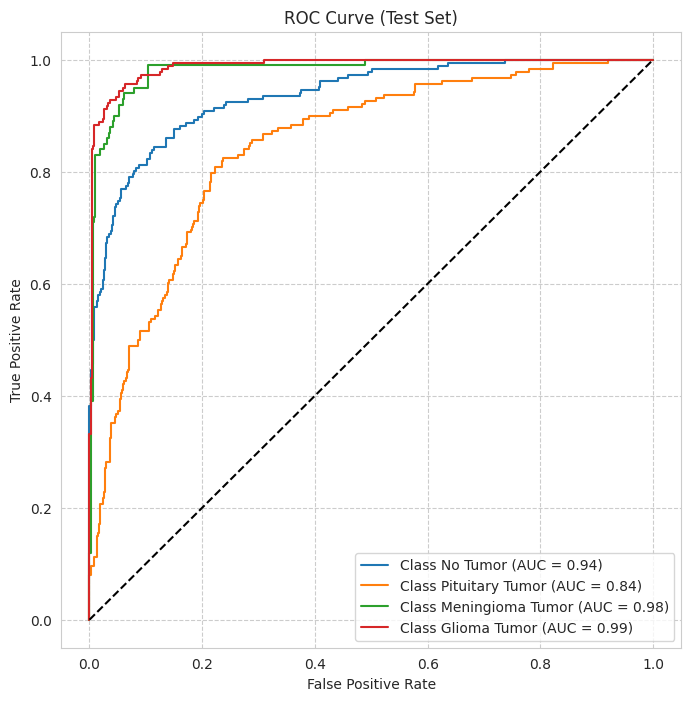

Classification Report on Test Set:
                  precision    recall  f1-score   support

        No Tumor       0.82      0.83      0.83       186
 Pituitary Tumor       0.82      0.76      0.79       188
Meningioma Tumor       0.91      0.86      0.88       100
    Glioma Tumor       0.88      0.97      0.92       181

        accuracy                           0.85       655
       macro avg       0.86      0.85      0.85       655
    weighted avg       0.85      0.85      0.85       655



In [ ]:
test_steps = ceil(test_generator.samples / test_generator.batch_size)
y_pred_test = densenet121_model.predict(test_generator, steps=test_steps, verbose=1)
y_true_test = test_generator.classes  # Ensure matching lengths
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

# Calculate metrics on the test set
acc_test = accuracy_score(y_true_test, y_pred_classes_test)
densenet121_auc_score_test = roc_auc_score(to_categorical(y_true_test), y_pred_test, multi_class='ovo')
f1_test = f1_score(y_true_test, y_pred_classes_test, average='weighted')
precision_test = precision_score(y_true_test, y_pred_classes_test, average='weighted')
recall_test = recall_score(y_true_test, y_pred_classes_test, average='weighted')
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)

# ROC curve on test set
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_test == i, y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Display results on the test set
print("Test Set Results:")
print(f"Accuracy: {acc_test}")
print(f"AUC: {densenet121_auc_score_test}")
print(f"F1 Score: {f1_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"Confusion Matrix: \n{cm_test}\n")

# Plot ROC curve on test set
plt.figure(figsize=(8, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()

# Classification report on test set
print("Classification Report on Test Set:")
print(classification_report(y_true_test, y_pred_classes_test, target_names=classes))


In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [ ]:
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 3211908 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
resnet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               12845184  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 36433412 (138.98 MB)
Trainable params: 12845700 (49.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
densenet121_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 7169220 (27.35 MB)
Trainable params: 131716 (514.52 KB)
Non-trainable params: 7037504 (26.85 MB)
_________